In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import csv
import sys
import os
import pickle
import random
import numpy as np
import time
import operator
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

from collections import Counter

# import statsmodels.stats.api as sms
# import statsmodels.formula.api as smf
# import statsmodels.api as sm

import scipy.stats
from scipy.stats import entropy
from scipy.stats import spearmanr, pearsonr
from scipy.stats import zscore

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score, KFold

import xgboost as xgb
import shap

In [3]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [4]:
csfont = {'fontname':'Comic Sans MS'}
hfont = {'fontname':'Helvetica'}

In [5]:
plt.rcParams["font.family"] = "sans-serif"

In [6]:
sys.path.append('../python')
from permutation import permutation, compute_alignment_strength
from utils.utils_funcs import get_variance, get_distinctness, get_distinctness_from_nearest_5, aggregate_embeddings_visual_and_language
from utils.utils_funcs import load_data_to_dict

In [7]:
def combine_nouns_and_verbs(struct1,struct2):
    words_full=list()
    embeds_full=dict()
    for w in struct1["embeds"]:
        ww=w+"_n"
        temp=dict()
        temp["visual"]=struct1["embeds"][w]["visual"]
        temp["language"]=struct1["embeds"][w]["language"]
        embeds_full[ww]=temp
        words_full.append(ww)
    for w in struct2["embeds"]:
        ww=w+"_v"
        temp=dict()
        temp["visual"]=struct2["embeds"][w]["visual"]
        temp["language"]=struct2["embeds"][w]["language"]
        embeds_full[ww]=temp
        words_full.append(ww)
    data_full=dict(
        embeds=embeds_full,
        words=words_full
    )
    return data_full

In [8]:
def get_concept_level_alignment_strength(struct,concepts,targets):
    visual_embeddings_list=list()
    langauge_embeddings_list=list()
    for concept in concepts:
        embeddings=struct["embeds"][concept]
        visual_embeddings_list.append(embeddings["visual"])
        langauge_embeddings_list.append(embeddings["language"])
    z_0=np.array(visual_embeddings_list)
    z_1=np.array(langauge_embeddings_list)
    sim_z_0=cosine_similarity(z_0)
    sim_z_1=cosine_similarity(z_1)
    rt=list()
    for target in targets:
        idx=concepts.index(target)
        aln=spearmanr(sim_z_0[idx],sim_z_1[idx])[0]
        if aln>0:
            rt.append(aln)
        else:
            rt.append(0)
    return rt

In [9]:
def combine_all_data(data,aoa_dict,v_var_dict,l_var_dict,v_dist_dict,l_dist_dict,freq_dict):
    aoas=list()
    v_vars=list()
    l_vars=list()
    v_dists=list()
    l_dists=list()
    freqs=list()
    
    intersect_concepts=list()
    for concept in aoa_dict:
        if concept not in freq_dict:
            print(concept)
        elif concept in data['words']:
            aoas.append(aoa_dict[concept])
            v_vars.append(v_var_dict[concept])
            l_vars.append(l_var_dict[concept])
            v_dists.append(v_dist_dict[concept])
            l_dists.append(l_dist_dict[concept])
            freqs.append(freq_dict[concept])
            intersect_concepts.append(concept)
    alignments=get_concept_level_alignment_strength(data,data['words'],intersect_concepts)
    return aoas,alignments,v_vars,l_vars,v_dists,l_dists,freqs

-----

In [10]:
# vg_noun_data=pickle.load(open("../data/dumped_embeddings/vg_noun_swav_bert_window5_20.pkl","rb"))
# vg_verb_data=pickle.load(open("../data/dumped_embeddings/vg_verb_swav_bert_window5_20.pkl","rb"))

# aggregated_vg_noun_data=aggregate_embeddings_visual_and_language(vg_noun_data,20,20)
# aggregated_vg_verb_data=aggregate_embeddings_visual_and_language(vg_verb_data,20,20)

In [11]:
# vg_noun_data=pickle.load(open("../data/dumped_embeddings/vg_noun_concept_least20_swav_bert_20.pkl","rb"))
# vg_verb_data=pickle.load(open("../data/dumped_embeddings/vg_verb_concept_least20_swav_bert_20.pkl","rb"))

# aggregated_vg_noun_data=aggregate_embeddings_visual_and_language(vg_noun_data,20,20)
# aggregated_vg_verb_data=aggregate_embeddings_visual_and_language(vg_verb_data,20,20)

In [12]:
# vg_noun_data=pickle.load(open("../data/dumped_embeddings/vg_noun_concept_least20_swav_glove_20.pkl","rb"))
# vg_verb_data=pickle.load(open("../data/dumped_embeddings/vg_verb_concept_least20_swav_glove_20.pkl","rb"))

# aggregated_vg_noun_data=aggregate_embeddings_visual_and_language(vg_noun_data,20,1)
# aggregated_vg_verb_data=aggregate_embeddings_visual_and_language(vg_verb_data,20,1)

In [13]:
# vg_noun_data=pickle.load(open("../data/dumped_embeddings/vg_noun_ll_swav_bert_20.pkl","rb"))
# vg_verb_data=pickle.load(open("../data/dumped_embeddings/vg_verb_ll_swav_bert_20.pkl","rb"))

# aggregated_vg_noun_data=aggregate_embeddings_visual_and_language(vg_noun_data,20,20)
# aggregated_vg_verb_data=aggregate_embeddings_visual_and_language(vg_verb_data,20,20)

In [14]:
# vg_noun_data=pickle.load(open("../data/dumped_embeddings_replication/vg_noun_least20_ll_swav_bert_20.pkl","rb"))
# vg_verb_data=pickle.load(open("../data/dumped_embeddings_replication/vg_verb_least20_ll_swav_bert_20.pkl","rb"))

# aggregated_vg_noun_data=aggregate_embeddings_visual_and_language(vg_noun_data,20,20)
# aggregated_vg_verb_data=aggregate_embeddings_visual_and_language(vg_verb_data,20,20)

In [15]:
vg_noun_data=pickle.load(open("../data/dumped_embeddings_replication/vg_noun_least20_ll_2nd_swav_bert_20.pkl","rb"))
vg_verb_data=pickle.load(open("../data/dumped_embeddings_replication/vg_verb_least20_ll_2nd_swav_bert_20.pkl","rb"))

aggregated_vg_noun_data=aggregate_embeddings_visual_and_language(vg_noun_data,20,20)
aggregated_vg_verb_data=aggregate_embeddings_visual_and_language(vg_verb_data,20,20)

In [16]:
vg_all_data=combine_nouns_and_verbs(vg_noun_data,vg_verb_data)
aggregated_vg_all_data=aggregate_embeddings_visual_and_language(vg_all_data,20,20)

----

In [17]:
# noun_aoa_dict=load_data_to_dict("../data/processed/aoa/kuperman_noun_aoa.txt",concepts=vg_noun_data["words"])
# verb_aoa_dict=load_data_to_dict("../data/processed/aoa/kuperman_verb_aoa.txt",concepts=vg_verb_data["words"])

# noun_aoa_sorted = sorted(noun_aoa_dict.items(), key=operator.itemgetter(1))
# verb_aoa_sorted = sorted(verb_aoa_dict.items(), key=operator.itemgetter(1))

In [18]:
noun_aoa_dict=load_data_to_dict("../data/processed/aoa/wordbank_noun_aoa.txt",concepts=vg_noun_data["words"])
verb_aoa_dict=load_data_to_dict("../data/processed/aoa/wordbank_verb_aoa.txt",concepts=vg_verb_data["words"])

noun_aoa_sorted = sorted(noun_aoa_dict.items(), key=operator.itemgetter(1))
verb_aoa_sorted = sorted(verb_aoa_dict.items(), key=operator.itemgetter(1))

In [19]:
# noun_aoa_dict=load_data_to_dict("../data/processed/aoa/glasgow_noun_aoa.txt",concepts=vg_noun_data["words"])
# verb_aoa_dict=load_data_to_dict("../data/processed/aoa/glasgow_verb_aoa.txt",concepts=vg_verb_data["words"])

# noun_aoa_sorted = sorted(noun_aoa_dict.items(), key=operator.itemgetter(1))
# verb_aoa_sorted = sorted(verb_aoa_dict.items(), key=operator.itemgetter(1))

In [20]:
all_aoa_dict=dict()
for w in noun_aoa_dict:
    ww=w+"_n"
    all_aoa_dict[ww]=noun_aoa_dict[w]
for w in verb_aoa_dict:
    ww=w+"_v"
    all_aoa_dict[ww]=verb_aoa_dict[w]

----

In [21]:
noun_freq_dict=load_data_to_dict("../data/processed/childes_noun_freq.txt",header=True)
verb_freq_dict=load_data_to_dict("../data/processed/childes_verb_freq.txt",header=True)

In [22]:
all_freq_dict=dict()
for w in noun_freq_dict:
    ww=w+"_n"
    all_freq_dict[ww]=noun_freq_dict[w]
for w in verb_freq_dict:
    ww=w+"_v"
    all_freq_dict[ww]=verb_freq_dict[w]

----

## nouns+verbs

In [ ]:
all_visual_variability,all_language_variability=get_variance(vg_all_data)

In [ ]:
all_visual_discriminability,all_language_discriminability=get_distinctness(vg_all_data)

----

In [ ]:
aoas,alignments,v_vars,l_vars,v_dists,l_dists,freqs=combine_all_data(aggregated_vg_all_data,
                                                                     all_aoa_dict,
                                                                     all_visual_variability,
                                                                     all_language_variability,
                                                                     all_visual_discriminability,
                                                                     all_language_discriminability,
                                                                     all_freq_dict)

In [ ]:
df=pd.DataFrame(data=np.transpose(np.array([aoas,alignments,v_vars,l_vars,v_dists,l_dists,freqs])),columns=['aoa','alignment','v_variability','l_variability','v_discriminability','l_discriminability','frequency'])
# df1['type']='noun'

In [ ]:
# df

In [ ]:
# df['type']=df['type'].astype("category")

In [ ]:
# df.dtypes

### Xgboost

In [ ]:
x=df.iloc[:,1:]

In [ ]:
y=df.iloc[:,:1]

In [ ]:
# # Shuffling the data
# X_shuffle, y_shuffle = shuffle(x, y)

In [ ]:
# xgb_rg = xgb.XGBRegressor(max_depth=3, n_estimators=100,
#                             objective ='reg:linear', booster='gbtree',
#                             n_jobs=2)

# # Cross-validation with 10 folds
# mse = cross_val_score(xgb_rg, X_shuffle, y_shuffle,
#                          scoring='neg_mean_squared_error',
#                          cv=10, n_jobs=-1)

# print("MSE Values: ", -1 * np.round(mse, 2))
# print("Average MSE: ", -1 * np.mean(mse))

In [ ]:
test_size=0.2
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_size)

In [ ]:
# xgb_full= xgb.DMatrix(x, label=y)
# xgb_train = xgb.DMatrix(X_train, label=y_train)
# xgb_test = xgb.DMatrix(X_test, label=y_test)

In [ ]:
# params = {
#     "eta": 0.002,
#     "max_depth": 5,
#     "subsample": 0.5
# }
# model_train = xgb.train(params, xgb_train, 10000, evals = [(xgb_test, "test")], verbose_eval=1000)

In [ ]:
# explainer = shap.Explainer(model_train)
# shap_values = explainer(xgb_full)
# shap.plots.bar(shap_values)

In [ ]:
# xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
#                 max_depth = 5, alpha = 10, n_estimators = 10, tree_method="hist", enable_categorical=True)
xg_reg = xgb.XGBRegressor(max_depth=6,subsample=0.5,n_estimators=10000,learning_rate=0.002)

In [ ]:
model=xg_reg.fit(X_train,y_train)

In [ ]:
preds = xg_reg.predict(X_test)

In [ ]:
r=pearsonr(np.array(y_test).squeeze(),np.array(preds))[0]
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("Pearson correlation: %f" % (r))
print("RMSE: %f" % (rmse))

In [ ]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(model)
shap_values = explainer(x)

In [ ]:
# # visualize the first prediction's explanation
# shap.plots.waterfall(shap_values[0])

In [ ]:
shap.summary_plot(shap_values, x)

In [ ]:
shap.plots.bar(shap_values)

In [ ]:
# create a dependence scatter plot to show the effect of a single feature across the whole dataset
shap.plots.scatter(shap_values[:,"alignment"], color=shap_values)

In [ ]:
shap.plots.scatter(shap_values[:,"l_variability"], color=shap_values)

### Linear Regression

In [ ]:
# results = smf.ols(formula = 'aoa ~ alignment+v_variability+l_variability+v_discriminability+l_discriminability',data=df).fit()

In [ ]:
# results.summary()

## nouns and verbs respectively

In [23]:
noun_visual_variability,noun_language_variability=get_variance(vg_noun_data)
verb_visual_variability,verb_language_variability=get_variance(vg_verb_data)

In [24]:
noun_visual_discriminability,noun_language_discriminability=get_distinctness(vg_noun_data)
verb_visual_discriminability,verb_language_discriminability=get_distinctness(vg_verb_data)

In [25]:
aoas,alignments,v_vars,l_vars,v_dists,l_dists,freqs=combine_all_data(aggregated_vg_noun_data,noun_aoa_dict,
                                                              noun_visual_variability,noun_language_variability,
                                                              noun_visual_discriminability,noun_language_discriminability,
                                                                    noun_freq_dict)

In [26]:
df1=pd.DataFrame(data=np.transpose(np.array([aoas,alignments,v_vars,l_vars,v_dists,l_dists,freqs])),columns=['aoa','alignment','visual_var','lang_var','visual_dis','lang_dis','frequency'])
df1['type']=0

In [27]:
# df1

In [28]:
aoas,alignments,v_vars,l_vars,v_dists,l_dists,freqs=combine_all_data(aggregated_vg_verb_data,verb_aoa_dict,
                                                              verb_visual_variability,verb_language_variability,
                                                              verb_visual_discriminability,verb_language_discriminability,
                                                                    verb_freq_dict)

In [29]:
df2=pd.DataFrame(data=np.transpose(np.array([aoas,alignments,v_vars,l_vars,v_dists,l_dists,freqs])),columns=['aoa','alignment','visual_var','lang_var','visual_dis','lang_dis','frequency'])
df2['type']=1

In [30]:
# df2

In [31]:
df=pd.concat([df1,df2])

In [32]:
df.head()

,aoa,alignment,visual_var,lang_var,visual_dis,lang_dis,frequency,type
0,17.0,0.141047,0.901835,9.098234,1.155025,13.945785,3410.0,0
1,17.0,0.390946,0.781586,9.511187,1.088986,14.066430,13592.0,0
2,17.0,0.339686,0.574474,10.290210,1.007442,14.296301,1820.0,0
3,17.0,0.214414,0.524033,9.852293,0.979389,14.479797,5888.0,0
4,18.0,0.163115,0.620925,7.891148,1.158732,13.066875,7092.0,0


In [33]:
# df['type']=df['type'].astype("category")

In [34]:
# df.dtypes

### Xgboost

In [35]:
x=df.iloc[:,1:]

In [36]:
y=df.iloc[:,:1]

In [37]:
test_size=0.2
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_size)

In [38]:
# Xy = xgb.DMatrix(X, y, enable_categorical=True)
# params = {
#     "eta": 0.002,
#     "max_depth": 6,
#     "subsample": 0.5
# }
# booster = xgb.train({"tree_method": "hist", "max_cat_to_onehot": 5}, Xy)

In [39]:
# xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
#                 max_depth = 5, alpha = 10, n_estimators = 10, tree_method="hist", enable_categorical=True)
xg_reg = xgb.XGBRegressor(max_depth=10,subsample=0.5,n_estimators=10000,learning_rate=0.02)

In [40]:
model=xg_reg.fit(X_train,y_train)

preds = xg_reg.predict(X_test)

In [41]:
r=pearsonr(np.array(y_test).squeeze(),np.array(preds))[0]
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("Pearson correlation: %f" % (r))
print("RMSE: %f" % (rmse))

Pearson correlation: 0.404321
RMSE: 2.672218


In [42]:
# # explain the model's predictions using SHAP
# # (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
# explainer = shap.Explainer(model)
# shap_values = explainer(x)

In [43]:
shap_values = shap.TreeExplainer(model).shap_values(X_train)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [44]:
# # visualize the first prediction's explanation
# shap.plots.waterfall(shap_values[0])

In [45]:
# summarize the effects of all the features
# shap.plots.beeswarm(shap_values, show=False, color_bar=False)
# plt.colorbar()
# plt.show()

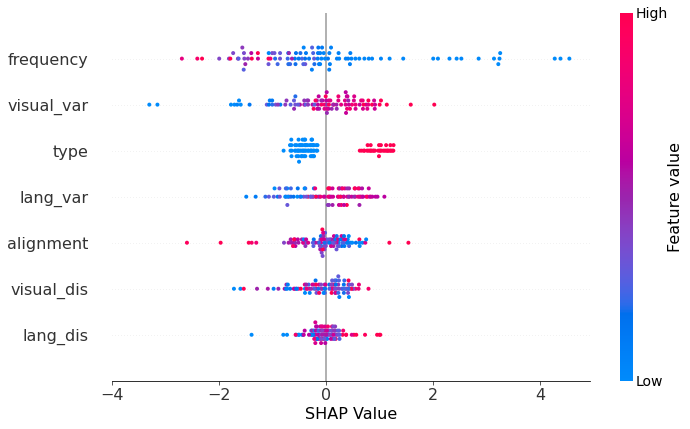

In [46]:
f = plt.figure()
shap.summary_plot(shap_values, X_train, show=False)

fig, ax = plt.gcf(), plt.gca()
# main figure settings
fig.set_size_inches(10, 6)
ax.tick_params(labelsize=16)
ax.set_xlabel("SHAP Value",fontsize=16)
plt.xticks([-4,-2,0,2,4])

# color bar settings
cb_ax = fig.axes[1]

cb_ax.tick_params(labelsize=14)
cb_ax.set_ylabel("Feature value", fontsize=16)

cb_ax.set_aspect('auto')
plt.tight_layout()
cb_ax.set_box_aspect(30) 

f.savefig("../figs/vg_shap_summary.png", bbox_inches='tight', dpi=600)

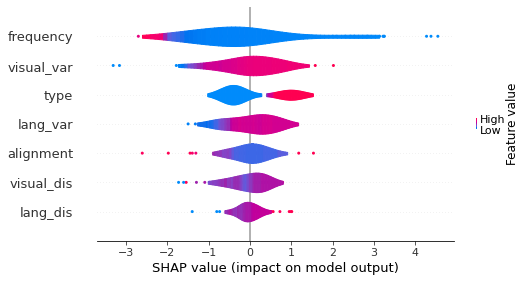

In [47]:
shap.summary_plot(shap_values, X_train, plot_type='violin')

In [48]:
# shap.summary_plot(shap_values, plot_type='violin')

In [49]:
# shap.summary_plot(shap_values, X_train, plot_type='bar')

In [50]:
def ABS_SHAP(df_shap,df):
    #import matplotlib as plt
    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')

    # Plot it
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)
    colorlist = k2['Sign']
    

    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(10,6),legend=False, fontsize=16)
    figure_size = plt.gcf().get_size_inches()
    print(figure_size)
    for i, v in enumerate(k2['SHAP_abs']):
        ax.text(v+0.02, i-0.1, "{:.2f}".format(v), color='black', fontsize=16)
    ax.set_xlabel("SHAP Value (Red = Positive Impact)",fontsize=16)
    # xticks=range(0,2,0.2)
    # ax.xticks(xticks,xticks)
    plt.xlim(0, 1.6)
    ax.set_xticks([0,0.5,1.0,1.5])
    ax.set_ylabel("")
    plt.savefig("../figs/vg_shap_summary_value.png", bbox_inches='tight', dpi=1000)
    

[10.  6.]


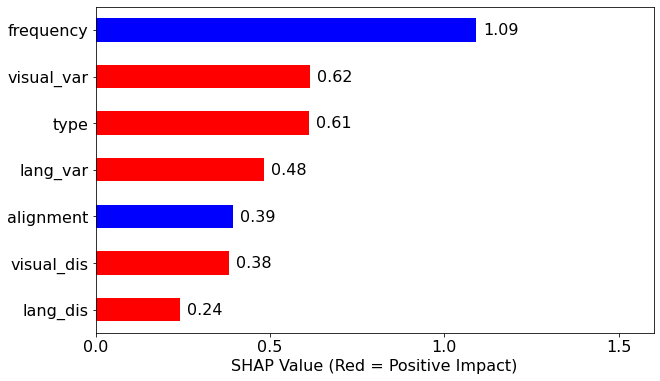

In [51]:
ABS_SHAP(shap_values,X_train)

In [ ]:
# shap.plots.bar(shap_values)

In [ ]:
# create a dependence scatter plot to show the effect of a single feature across the whole dataset
shap.plots.scatter(shap_values[:,"alignment"], color=shap_values)

In [ ]:
# create a dependence scatter plot to show the effect of a single feature across the whole dataset
shap.plots.scatter(shap_values[:,"v_discriminability"], color=shap_values)

In [ ]:
# create a dependence scatter plot to show the effect of a single feature across the whole dataset
shap.plots.scatter(shap_values[:,"l_discriminability"], color=shap_values)

In [ ]:
shap.plots.scatter(shap_values[:,"l_variability"], color=shap_values)

In [ ]:
shap.plots.scatter(shap_values[:,"v_variability"], color=shap_values)

### Linear Regression

In [ ]:
results = smf.ols(formula = 'aoa ~ frequency+alignment+v_variability+l_variability+v_discriminability+l_discriminability',data=df).fit()

In [ ]:
results.summary()